In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('science')
plt.rcParams['text.usetex'] = True
#import seaborn; seaborn.set()
import astropy.io.fits as fits
from astropy.io import ascii
from astropy.table import Table
import os
import re
import math
from pandas import DataFrame
import pandas as pd
import sys
# 定义颜色
colors = {
    'red': '#E24A33',
    'blue': '#348ABD',
    'green': '#8EBA42',
    'orange': '#FBC15E',
    'purple': '#988ED5',
    'pink': '#FFB5B8',
    'gray': '#777777'
}

def readfile(tfile): 
    with open(tfile,'r') as f:
        lines=f.readlines()
    return lines

In [2]:
def read_fitresults(source,files,Models,N_Unitsi,path0):
    print(files)
    #MJD = read_MJD(files,path0)
    f = open("%s/%s"%(source,files),"r")
    all=f.read()
    #print(all)
    line_tails=readfile("%s/%s"%(source,files))
    j=0
    pars_values=[]
    pars_names=[]
    while j < len(Models):
        pars=re.findall(r"%s.*"%Models[j], all)
        #print(pars)
        l=len(N_Units[j])
        while l > 0:
            p=N_Units[j][-l]
            if Long_index[j] > 1:
                pars_values.append(float(pars[-l-(Long_index[j]-1)*len(N_Units[j])].split()[2+p]))
                name_str=Models[j]+'%s'%Long_index[j]+'_'+pars[-l].split()[1]
                pars_names.append(name_str)
                l-=1
            else:
                pars_values.append(float(pars[-l].split()[2+p]))
                name_str=Models[j]+'%s'%Long_index[j]+'_'+pars[-l].split()[1]
                pars_names.append(name_str)
                l-=1
        j+=1
    par_chi=re.findall(r"Test statistic : Chi-Squared.*", all)
    #print(par_chi[-1].split())
    dofall=re.findall(r"Null hypothesis probability.*", all)
    #print(dofall[-1].split())
    chi2=par_chi[-1].split()[4]
    # print(chi2)
    dof=dofall[-1].split()[6]
    # print(dof)
    red_chi2=float(chi2)/float(dof)
    # print(red_chi2)
    return pars_names, pars_values, red_chi2

In [3]:
def read_errs(source,files,errs,pars_names,pars_values):
    f = open("%s/%s"%(source,files),"r")
    all=f.read()
    #print(all)
    line_tails=readfile("%s/%s"%(source,files))
    Err=re.findall(r"Parameter   Confidence Range.*", all)
    l=0
    while l < len(line_tails):
        if Err[0] in line_tails[l]:
            L=l
        else:
            pass
        l+=1
    for e in errs:
        Errs_results=[line_tails[L+1+a].split() for a in range(len(errs))]
    pars_Err_lh=[]
    NE=0
    while NE < len(errs):
        err_low=float(Errs_results[NE][1])
        err_high=float(Errs_results[NE][2])
        pars_Err_lh.append([err_low,err_high])
        NE+=1
    #print(pars_values)
    #get err
    Np=0
    err_LR=[]
    while Np < len(pars_values):
        err_L=pars_values[Np]-pars_Err_lh[Np][0]
        err_R=pars_Err_lh[Np][1]-pars_values[Np]
        err_LR.append([err_L,err_R])
        Np+=1
    err_names_L=["%s_Lerrs"%Name for Name in pars_names]
    err_names_R=["%s_Rerrs"%Name for Name in pars_names]

    err_L=[i[0] for i in err_LR]
    err_R=[i[1] for i in err_LR]

    return err_names_L,err_L,err_names_R,err_R

In [4]:
source="/Volumes/WD_BLACK/Data/1A0535p262/HXMT/HHT/20201120_QPOphase/fit_results_flux"
path0="/Volumes/WD_BLACK/Data/1A0535p262/HXMT/HHT/20201120_QPOphase/fit_results_flux"
files=os.listdir("%s"%source)
Models=['cflux']
N_Units=[[1]]
errs=[5]
#errs=[11]
Long_index=[1]

i=0
red_chi2_all=[]
while i < len(files):
#while i < 1:
    #pars_names, pars_values,red_chi2,dof, MJD, Lum, Lum_errL, Lum_errR=read_fitresults(source,files[i],Models,N_Units,path0)
    pars_names, pars_values, red_chi2=read_fitresults(source,files[i],Models, N_Units,path0)
    red_chi2_all.append(red_chi2)
    #print(red_chi2)
    #print(pars_names)
    fit_names=pars_names
    fit_data=pars_values

    err_names_L, err_L, err_names_R, err_R=read_errs(source,files[i],errs,pars_names,pars_values)
    #print(err_names_L)
    #err_names_L, err_L = err_names_L+['Lum_errL'], err_L+[Lum_errL]
    #err_names_R, err_R = err_names_R+['Lum_errR'], err_R+[Lum_errR]
    
    derr_L=dict(zip(err_names_L,err_L))
    derr_R=dict(zip(err_names_R,err_R))
    if i==0:
        d1 = dict(zip(fit_names,fit_data))
        Para=pd.DataFrame(d1,index=['%s'%files[i]])
        Para_errL=pd.DataFrame(derr_L,index=['%s'%files[i]])
        Para_errR=pd.DataFrame(derr_R,index=['%s'%files[i]])
        i+=1
    else:
        Para.loc['%s'%files[i]]=fit_data
        Para_errL.loc['%s'%files[i]]=err_L
        Para_errR.loc['%s'%files[i]]=err_R
        i+=1
Para_all=pd.concat([Para,Para_errL,Para_errR],axis=1)
#save_data="fit_comptt_final.csv"
#Para_all.to_csv(save_data)
print(Para_all.columns)
M=len(errs)
print(M)
names=Para_all.columns[:M]
print(names)

phase_0001.txt
phase_0102.txt
phase_0203.txt
phase_0304.txt
phase_0405.txt
phase_0506.txt
phase_0607.txt
phase_0708.txt
phase_0809.txt
phase_0910.txt
Index(['cflux1_lg10Flux', 'cflux1_lg10Flux_Lerrs', 'cflux1_lg10Flux_Rerrs'], dtype='object')
1
Index(['cflux1_lg10Flux'], dtype='object')


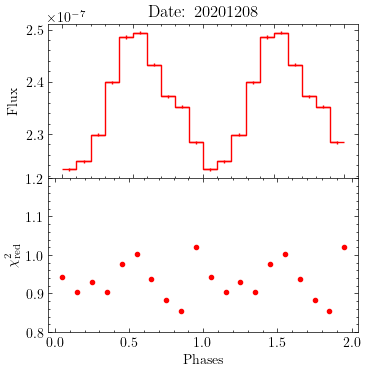

In [5]:
X = np.array([0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95])
x_data=np.hstack([X,X+1])
X_err=np.array([0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05])
x_err=np.hstack([X_err,X_err])
fig, axs = plt.subplots(M+1,1,figsize=(4, 4))
Ylabels=[r'Flux']
axs[0].set_title('Date: 20201208')
i=0
while i < len(names):
    name=names[i]
    y1=Para_all['%s'%name].values
    #print(np.mean(y1))
    y1_err=0.5*(abs(Para_all['%s_Lerrs'%name].values)+abs(Para_all['%s_Rerrs'%name].values))
    y1=np.hstack([y1,y1])
    y1_pow_10 = np.power(10, y1)
    y1_err=np.hstack([y1_err,y1_err])
    y1_err_new = y1_err * np.log(10) * y1_pow_10
    axs[0+i].errorbar(x_data,y1_pow_10,xerr=x_err,yerr=y1_err_new,drawstyle='steps-mid',color='r',ecolor='r')
    #axs2 = axs[0+i].twinx()
    #axs2.errorbar(phase_bins, profile, drawstyle='steps-mid',color='k',ecolor='k')
    axs[0+i].set_ylabel(Ylabels[i])
    #axs2.set_ylabel(r'Pulse (cts/s)')
    plt.xlabel('Phases')
    i+=1
#plot reduced chi^2 of fitting: 
axs[0+i].errorbar(x_data,np.hstack([red_chi2_all,red_chi2_all]),fmt='.',color='r',ecolor='r')
axs[0+i].set_ylim(0.8,1.2)
axs[0+i].set_ylabel(r'$\chi^2_{\rm red}$')
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig('20201204_paras.pdf')

In [6]:
Y=np.array(Para_all['%s' % name].values)
#Y_err=0.5*(abs(Para_all['%s_Lerrs'%name].values)+abs(Para_all['%s_Rerrs'%name].values))
print([np.power(10, Y)])
#print(Y_err*np.log(10)*np.power(10, Y))

[array([2.23187568e-07, 2.24786383e-07, 2.29879371e-07, 2.39916435e-07,
       2.48582184e-07, 2.49419268e-07, 2.43304421e-07, 2.37235676e-07,
       2.35217701e-07, 2.28444128e-07])]


In [7]:
std_deviation = np.std(y1_pow_10)

# 计算平均值
mean_value = np.mean(y1_pow_10)

# 计算标准差除以平均值
std_deviation_over_mean = std_deviation / mean_value
print("fractional RMS of flux is: ", std_deviation_over_mean)

fractional RMS of flux is:  0.037749812636336436


In [8]:
maxf = np.max(y1_pow_10)
minf = np.min(y1_pow_10)
frms=(maxf-minf)/(maxf+minf)
print("fractional RMS of flux is: ", frms)

fractional RMS of flux is:  0.055504274911040055


In [9]:
#fdcut
E_band=['2-5 keV','5-10 keV','10-15 keV','15-20 keV','20-25 keV',
        '25-30 keV','30-35 keV','35-40 keV','40-45 keV','45-50 keV',
        '50-55 keV','55-60 keV','60-65 keV','65-70 keV','70-75 keV',
        '75-80 keV','80-85 keV','85-90 keV','90-120 keV']
Ex=[3.5,7.5,12.5,17.5,22.5,
    27.5,32.5,37.5,42.5,47.5,
    52.5,57.5,62.5,67.5,72.5,
    77.5,82.5,87.5,105]
Ex=np.array(Ex)

rms_all=[0.011,0.019,0.020,0.019,0.027,
         0.044,0.067,0.095,0.126,0.149,
         0.158,0.152,0.137,0.122,0.111,
         0.105,0.098,0.086,0.062]
rms_all=np.array(rms_all)
rms_1=[0.011,0.019,0.020,0.020,0.025,
       0.036,0.048,0.059,0.068,0.075,
       0.082,0.087,0.091,0.095,0.099,
       0.103,0.106,0.109,0.118]
rms_1=np.array(rms_1)

max_index1 = np.argmax(rms_all)
max_index2 = np.argmax(rms_1)

print(rms_all[max_index1],rms_1[max_index2])
print(Ex[max_index1])

0.158 0.118
52.5


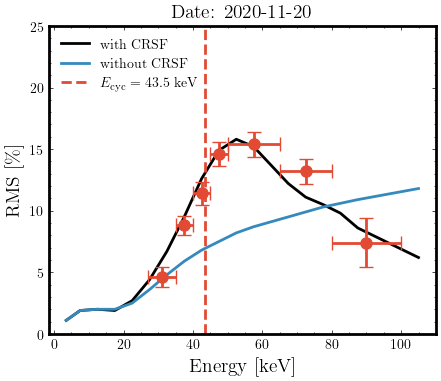

In [11]:
plt.figure(figsize=(5, 4))  
plt.plot(Ex,rms_all*100,'-k',label="with CRSF",lw=2)
plt.plot(Ex,rms_1*100,'-',color=colors['blue'],label="without CRSF",lw=2)

xrms=[31.0,37.5,42.5,47.5,57.5,72.5,90]
xrms_err=[4.0,2.5,2.5,2.5,7.5,7.5,10.0]

# yrms=[4.7,8.3,11.5,14.1,15.0,13.1,7.0]
# yrms_err=[0.7,1.0,1.1,1.4,1.4,1.2,1.8]

yrms=[4.6,8.8,11.4,14.6,15.4,13.2,7.4]
yrms_err=[0.8,0.8,0.9,1.0,1.0,1.0,2.0]

plt.errorbar(xrms, yrms, xerr=xrms_err, yerr=yrms_err, 
             fmt='o', color=colors['red'], ecolor=colors['red'], capsize=5, markersize=8, elinewidth=2)

Ecyc=43.5
plt.axvline(x=Ecyc, color=colors['red'], linestyle='--',lw=2, label=r"$E_{\rm cyc}=43.5$ keV")
plt.title('Date: 2020-11-20', fontsize=14, fontweight='bold',fontname='Times New Roman')
plt.xlabel('Energy [keV]', fontsize=14, fontweight='bold',fontname='Times New Roman')
plt.ylabel('RMS [\%]', fontsize=14, fontweight='bold',fontname='Times New Roman')
plt.ylim(0,25)
#plt.xscale('log')
#plt.legend()
# 设置四个边框加粗
ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
plt.legend(loc='upper left')
#plt.savefig('/Users/kldsky/Desktop/1A0535_results/fdcut/20201120_fdcut_flux.pdf')